In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import tqdm

import configs.deconv, configs.unet
from unet import UNet
from unet_deconv import UNetDeconv



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
def loss(output, target):
    return torch.nn.functional.mse_loss(output, target)

def train_loop(dataloader, model, loss_fn, optimizer, num_epochs=10):
    pbar = tqdm.tqdm(range(num_epochs), desc='Loss = N/A | Epochs')
    for _ in pbar:
        total_loss = 0
        for data in dataloader:
            pred = model(data)
            loss = loss_fn(pred, data)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f'Loss = {total_loss:.6f} | Epochs')

In [3]:
unet_model = UNet(**configs.unet.get_config().unet).to("cuda")
deconv_model = UNetDeconv(**configs.deconv.get_config().unet).to("cuda")

In [4]:
stripes_x = np.load("/home/songk/6.7960-final-project/data/stripes_x_32x32.npy")

In [6]:
input_img = stripes_x.astype(np.float32)[:8, :8, :8]
input_img = np.expand_dims(input_img, axis=0)
input_img = np.expand_dims(input_img, axis=0)
input_img = torch.from_numpy(input_img).to("cuda")
dataloader = DataLoader(input_img, batch_size=1, shuffle=True)

In [7]:
n = 0
x = deconv_model.down(input_img)
x = deconv_model.up.up_blocks[n](x)
vecs, radii, alphas, betas = deconv_model.up._get_radii_and_angles(x, deconv_model.up.scale_factors[n])
# radii = radii.unsqueeze(0)
upsample = torch.nn.Upsample(scale_factor=deconv_model.up.scale_factors[0])
x_upsampled = upsample(x)
vecs_embed = deconv_model.up.position_blocks[0](vecs)

In [9]:
x[0, 0]

tensor([[[0.0000, 0.7242],
         [0.7234, 0.0000]],

        [[0.5789, 1.1257],
         [1.1255, 0.5794]]], device='cuda:0', grad_fn=<SelectBackward0>)

In [10]:
x_upsampled[0, 0]

tensor([[[0.0000, 0.0000, 0.7242, 0.7242],
         [0.0000, 0.0000, 0.7242, 0.7242],
         [0.7234, 0.7234, 0.0000, 0.0000],
         [0.7234, 0.7234, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.7242, 0.7242],
         [0.0000, 0.0000, 0.7242, 0.7242],
         [0.7234, 0.7234, 0.0000, 0.0000],
         [0.7234, 0.7234, 0.0000, 0.0000]],

        [[0.5789, 0.5789, 1.1257, 1.1257],
         [0.5789, 0.5789, 1.1257, 1.1257],
         [1.1255, 1.1255, 0.5794, 0.5794],
         [1.1255, 1.1255, 0.5794, 0.5794]],

        [[0.5789, 0.5789, 1.1257, 1.1257],
         [0.5789, 0.5789, 1.1257, 1.1257],
         [1.1255, 1.1255, 0.5794, 0.5794],
         [1.1255, 1.1255, 0.5794, 0.5794]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [21]:
vecs_embed.shape

torch.Size([4, 4, 4, 9])

In [22]:
deconv_model.up.rebase_blocks[n](x_upsampled.transpose(1, 4)[0, 0, 0, 0, :], vecs_embed[0, 0, 0, :])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [6]:
# train_loop(dataloader, unet_model, loss, torch.optim.Adam(unet_model.parameters()), num_epochs=100)

Loss = 0.244521 | Epochs: 100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


In [7]:
train_loop(dataloader, deconv_model, loss, torch.optim.Adam(deconv_model.parameters()), num_epochs=100)

Loss = 0.413629 | Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


In [8]:
def viewer(image,x,y,z):
    plt.gray()
    fig, ax  = plt.subplots(1, 3)
    fig.tight_layout()

    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].imshow(image[:,:,z])
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('z')
    ax[1].imshow(np.flip(image[x,:,:].transpose()))
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('z')
    ax[2].imshow(image[:,y,:])
    ax[1].set_title(f"Slices at {x}, {y}, {z}")
    plt.show()

In [9]:
x = 7
y = 8
z = 20

<Figure size 640x480 with 0 Axes>

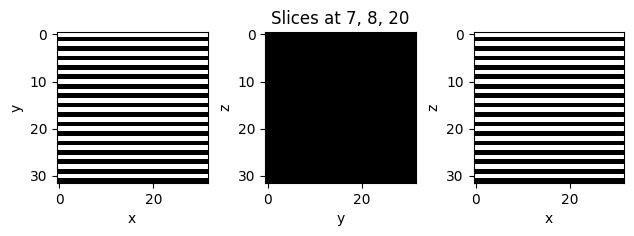

In [10]:
viewer(input_img[0,0].cpu().numpy(), x, y, z)

<Figure size 640x480 with 0 Axes>

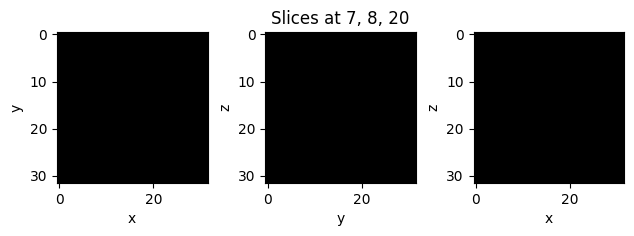

In [13]:
viewer(deconv_model(input_img).cpu().detach().numpy()[0, 0], x, y, z)

In [15]:
np.max(deconv_model(input_img).cpu().detach().numpy()[0, 0])

np.float32(0.09640317)